In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
from dataImporter import *
from dataProcesser import *
from events import sim_events, list_of_params, ic_params
from functions import perform_chisq
from scipy.stats import chi2
from event_processing import *
import pickle
from multiprocessing import Pool
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 100
matplotlib.rc('text', usetex=True)
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}')
np.set_printoptions(linewidth=200)

giunti_contour_cl90 = pd.read_csv('./data/giunti_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl90 = pd.read_csv('./data/ic_cl90.csv',header=None, names=['s24','dm41']).sort_values('dm41')
giunti_contour_cl99 = pd.read_csv('./data/giunti_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
IC_contour_cl99 = pd.read_csv('./data/ic_cl99.csv',header=None, names=['s24','dm41']).sort_values('dm41')
ic_34_cl90 = pd.read_csv('./data/ic_34_cl90.csv',header=None, names=['s24','s34']).sort_values('s34')
ic_34_cl99 = pd.read_csv('./data/ic_34_cl99.csv',header=None, names=['s24','s34']).sort_values('s34')

In [8]:
ndim = 4
N = 13
alpha = 0.99
precomputed_events = True

dm41_range = np.logspace(-1,0,20)#N=13 # np.logspace(-1,1,20) #N=9
s24_range =  np.logspace(-2,np.log10(0.2),30) #N=13 #np.logspace(-2,0,20)##N=9
s34_range = s24_range

param_list = list_of_params(ic_params, dm41_range, s24_range,s34_range=None,s24_eq_s34=True)
#for p in param_list: # Assert all dicts returned from param_list have precomputed probs.
#    assert is_precomputed(N=N,ndim=ndim, dict=p,check=False)

param_list = return_precomputed(N,ndim,params=param_list)
dm41_range = np.sort(np.unique(np.array([p['dm_41'] for p in param_list])))
s24_range = np.sin(2*np.sort(np.unique(np.array([p['theta_24'] for p in param_list]))))**2
s34_range = np.sin(2*np.sort(np.unique(np.array([p['theta_34'] for p in param_list]))))**2
print(dm41_range)
print(s24_range)
print(s34_range)

[0.1        0.11288379 0.1274275  0.14384499 0.16237767 0.18329807 0.20691381 0.23357215 0.26366509 0.29763514 0.33598183 0.37926902 0.42813324 0.48329302 0.54555948 0.61584821 0.6951928  0.78475997
 0.88586679 1.        ]
[0.01       0.01108825 0.01229493 0.01363293 0.01511654 0.0167616  0.01858569 0.02060828 0.02285098 0.02533774 0.02809513 0.03115259 0.03454278 0.0383019  0.04247012 0.04709194 0.05221673 0.05789923
 0.06420012 0.07118672 0.07893363 0.0875236  0.09704838 0.10760969 0.11932034 0.1323054  0.14670357 0.16266862 0.18037107 0.2       ]
[0.01       0.01108825 0.01229493 0.01363293 0.01511654 0.0167616  0.01858569 0.02060828 0.02285098 0.02533774 0.02809513 0.03115259 0.03454278 0.0383019  0.04247012 0.04709194 0.05221673 0.05789923
 0.06420012 0.07118672 0.07893363 0.0875236  0.09704838 0.10760969 0.11932034 0.1323054  0.14670357 0.16266862 0.18037107 0.2       ]


In [9]:
if not precomputed_events:
    p = Pool()
    data = [(alpha, N,p, False,False, [False, np.median(Ereco), 0]) for p in param_list]
    H1_events_list = p.starmap(sim_events, data)
    p.close()
    H0_events = sim_events(alpha=alpha,npoints=N,params=param_list[0], null=True, multi=False, spectral_shift=[False, np.median(Ereco), 0])
    if len(s34_range) > 1:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_34_N{N}_{len(dm41_range)}x{len(s24_range)}x{len(s34_range)}.p','wb'))
    else:
        pickle.dump(H1_events_list,open(f'./pre_computed/H1_no34_N{N}_{len(dm41_range)}x{len(s24_range)}.p','wb'))
    pickle.dump(H0_events,open(f'./pre_computed/H0_N{N}.p','wb'))

if len(s34_range) > 1:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_34_N{N}_{len(dm41_range)}x{len(s24_range)}x{len(s34_range)}.p','rb'))
else:
    H1_events_list = pickle.load(open(f'./pre_computed/H1_no34_N{N}_{len(dm41_range)}x{len(s24_range)}.p','rb'))
H0_events = pickle.load(open(f'./pre_computed/H0_N{N}.p','rb'))

gamma = 0.3
delta_T = (np.sum(sim_events(alpha=alpha,npoints=N,params=param_list[0], null=True, multi=False, spectral_shift=[True, np.median(Ereco), gamma])) - np.sum(H0_events))/np.sum(H0_events)

H0_normalized, H1_list_normalized = normalize_events(H0_events,H1_events_list,z_bins)

In [10]:
sigma_a = 0.25
sigma_b = 0.05
f = 0.08
s24_cl90, s24_cl99, dm41_cl90, dm41_cl99 = get_contour(H1_list_normalized, dm41_range,s24_range,delta_T,[sigma_a, sigma_b],f)

Text(0.05, 0.65, '$\\pi_N = 0.25$\n$\\pi_\\theta = 0.05$\n$\\Delta \\gamma = 0.3$\n$f = 0.08$\n')

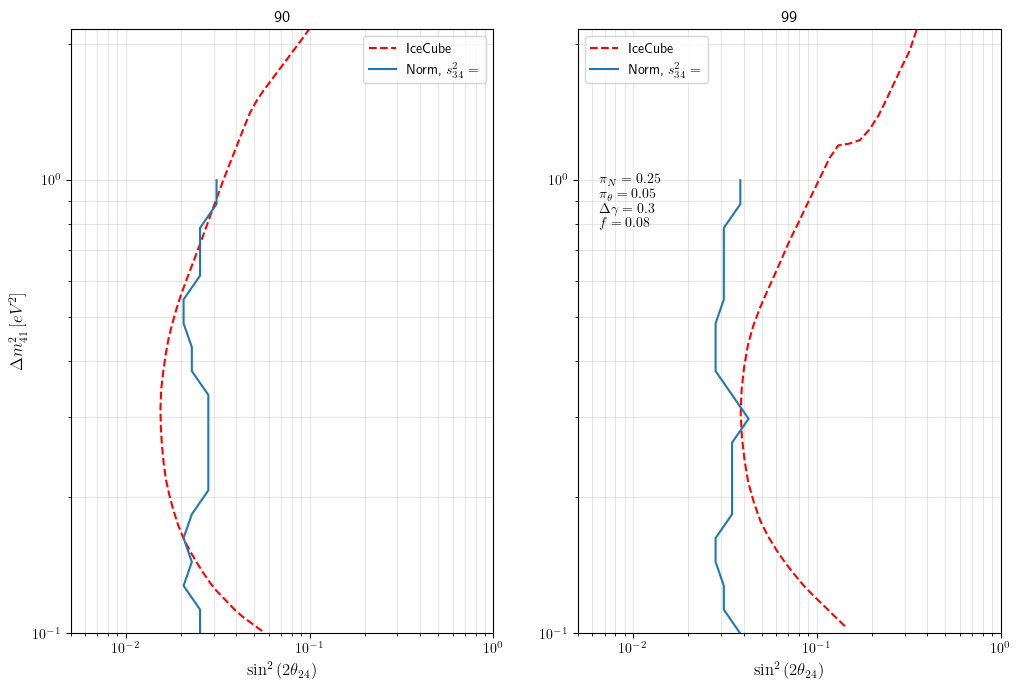

In [11]:
fig,ax = plt.subplots(1,2,figsize=(12,8))

#ax[0].plot(giunti_contour_cl90.s24, giunti_contour_cl90.dm41, label='Giunti et al. (90% CL)',c='b')
ax[0].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label='IceCube',c='red',ls='--')
ax[0].plot(s24_cl90, dm41_cl90, label='Norm, $s_{34}^2=$ ')


#ax[1].plot(giunti_contour_cl99.s24, giunti_contour_cl99.dm41, label='Giunti et al. (99% CL)',ls='solid',c='b')
ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label='IceCube',c='red',ls='--')
ax[1].plot(s24_cl99, dm41_cl99, label='Norm, $s_{34}^2=$')



ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim((5e-3, 1))
ax[1].set_xlim((5e-3, 1))
ax[0].set_ylim((1e-1,2.15))
ax[1].set_ylim((1e-1,2.15))
ax[0].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[1].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[0].set_ylabel('$\\Delta m^2_{41} \, [eV^2]$', fontsize=12)
ax[0].grid(True, which='both', alpha=0.3)
ax[1].grid(True, which='both', alpha=0.3)
ax[0].set_title('90% CL')
ax[1].set_title('99% CL')

ax[0].legend()
ax[1].legend()
plt.annotate(f'$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n', 
        xy=(0.05, 0.65), xycoords='axes fraction')

In [16]:
# Plots for Smirnov 2013
from plotter import P_over_E_parameter
temp_params = list_of_params(ic_params, np.array([1.]), np.array([0.1]), np.array([0,0.1,1]))
Pam = P_over_E_parameter('m', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=True)
Pm = P_over_E_parameter('m', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=False)
Pe = P_over_E_parameter('e', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=False)
Pae = P_over_E_parameter('e', param_dict_list=temp_params, E_range=np.logspace(3,4,50), theta_i = np.pi - np.arccos(-1), ndim = 4, anti=True)

Pamam = Pam[:,1]
Pmm = Pm[:,1]
Pem = Pe[:,1]
Paeam = Pae[:,1]

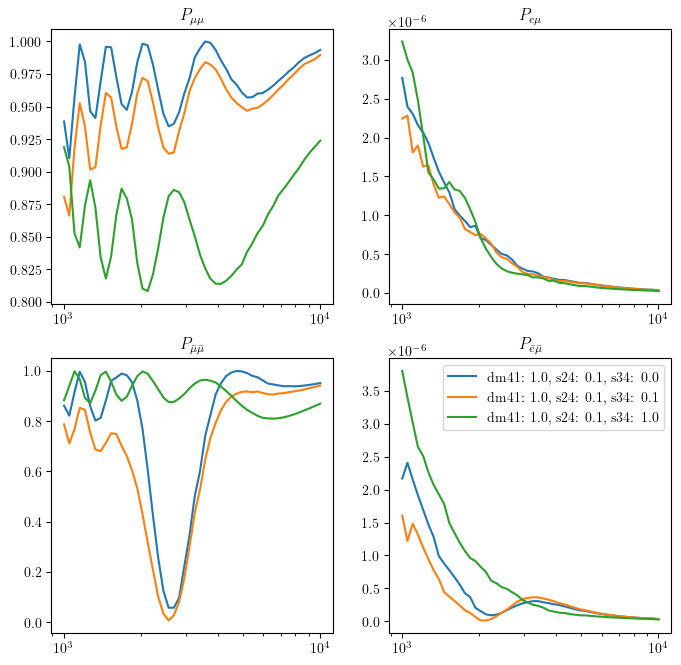

In [14]:
fig, ax = plt.subplots(2,2, figsize=(8,8))
ax = ax.flatten()
for i,prob in enumerate(Pmm):
    ax[0].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
for i,prob in enumerate(Pem):
    ax[1].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
for i,prob in enumerate(Pamam):
    ax[2].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
for i,prob in enumerate(Paeam):
    ax[3].plot(np.logspace(3,4,50), prob, label=f'dm41: {np.round(temp_params[i]["dm_41"],2)}, s24: {np.round(np.sin(2*temp_params[i]["theta_24"])**2,2)}, s34: {np.round(np.sin(2*temp_params[i]["theta_34"])**2,2)}')
ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')
ax[3].set_xscale('log')

ax[0].set_title('$P_{\mu\mu}$')
ax[1].set_title('$P_{e\mu}$')
ax[2].set_title('$P_{\\bar{\mu}\\bar{\mu}}$')
ax[3].set_title('$P_{\\bar{e}\\bar{\mu}}$')
plt.legend()

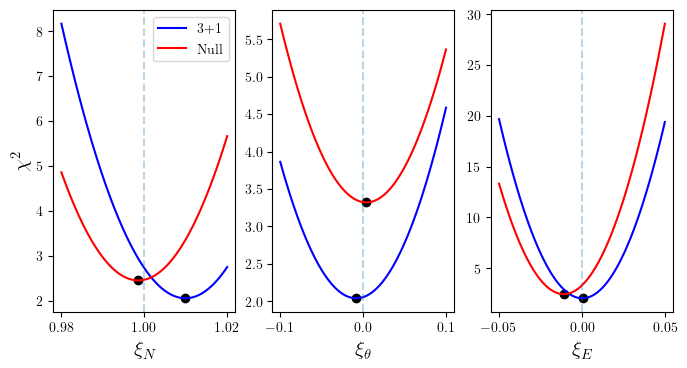

In [469]:
from functions import chisq
fig, ax = plt.subplots(1,3)
c_range = np.linspace(-0.05,0.05,100)
b_range = np.linspace(-0.1,0.1,100)
a_range = np.linspace(0.98,1.02,100)
H1_a = [chisq(params =[a,best_a[1]] ,events=best_fit_events, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for a in a_range]
H0_a = [chisq(params =[a,best_a[1]] ,events=H0_normalized, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for a in a_range]
H0_min_a = np.argmin(H0_a)
H1_min_a = np.argmin(H1_a)
ax[0].plot(a_range, H1_a, label='3+1', c='blue')
ax[0].plot(a_range, H0_a, label='Null', c='red')
ax[0].scatter(a_range[H0_min_a], H0_a[H0_min_a], c='black')
ax[0].set_xlabel('$\\xi_N$', fontsize=15)
ax[0].set_ylabel('$\chi^2$', fontsize=15)
ax[0].scatter(a_range[H1_min_a], H1_a[H1_min_a], c='black')
ax[0].legend()
ax[0].axvline(x=1, linestyle='--',alpha=0.3)


H1_b = [chisq(params =np.array([best_a[0],b]) ,events=best_fit_events, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for b in b_range]
H0_b = [chisq(params =np.array([best_a[0],b]) ,events=H0_normalized, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for b in b_range]
H0_min_b = np.argmin(H0_b)
H1_min_b = np.argmin(H1_b)
ax[1].plot(b_range, H1_b, label='3+1', c='blue')
ax[1].plot(b_range, H0_b, label='Null', c='red')
ax[1].scatter(b_range[H0_min_b], H0_b[H0_min_b], c='black')
ax[1].set_xlabel('$\\xi_\\theta$', fontsize=15)
ax[1].scatter(b_range[H1_min_b], H1_b[H1_min_b], c='black')
ax[1].axvline(x=0, linestyle='--',alpha=0.3)

H1_c = [chisq(params =np.array([best_a[0],best_a[1], c]) ,events=best_fit_events, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for c in c_range]
H0_c = [chisq(params =np.array([best_a[0],best_a[1], c]) ,events=H0_normalized, data=IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g) for c in c_range]
H0_min_c = np.argmin(H0_c)
H1_min_c = np.argmin(H1_c)
ax[2].plot(c_range, H1_c, label='3+1', c='blue')
ax[2].plot(c_range, H0_c, label='Null', c='red')
ax[2].scatter(c_range[H0_min_c], H0_c[H0_min_c], c='black')
ax[2].set_xlabel('$\\xi_E$', fontsize=15)
ax[2].scatter(c_range[H1_min_c], H1_c[H1_min_c], c='black')
ax[2].axvline(x=0, linestyle='--',alpha=0.3)

In [140]:
reshaped_H1 = np.array(H1_list_normalized).reshape(7,7,7,10,11)
best_dm = np.argwhere(dm41_range==best_fit_params['dm_41']).item()
H1_best_dm = reshaped_H1[:,:,best_dm,:]
H1_list_best_dm = H1_best_dm.reshape(7*7,10,11)

In [56]:
s24_cl90_index_list=[]
s24_cl99_index_list=[]
s34_cl90_index_list=[]
s34_cl99_index_list=[]
for x in [[1,0,0]]:#[[1.],[1.,0.],[1.,0.,0.]]:
    sigma_a = 0.25
    sigma_b = 0.15
    sigma_g = delta_T
    f = 0.09
    sigma_syst = f*IC_observed
    x0=x
    #chisq_H0, a_H0 = perform_chisq(H0_normalized,IC_observed,z=zreco[0:-1],sigma_a=sigma_a,sigma_b=sigma_b,sigma_gamma=sigma_gamma , x0=x0)
    chisq_H1_list  = np.array([perform_chisq(H1_norm, IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1], sigma_a=sigma_a,sigma_b=sigma_b,sigma_g=sigma_g, x0=x0)[0] for H1_norm in H1_list_normalized])
    delta_chi = chisq_H1_list - np.min(chisq_H1_list)#chisq_H1_list - chisq_H0

    best_fit_index = np.argmin(delta_chi)
    best_fit_params = param_list[best_fit_index]
    best_fit_events = H1_list_normalized[best_fit_index]
    _, best_a =perform_chisq(H1_list_normalized[best_fit_index], IC_observed,sigma_syst=sigma_syst,z=zreco[0:-1],sigma_a=sigma_a, sigma_b=sigma_b,sigma_g=sigma_g, x0=x0)
    p_value = chi2.sf(np.min(chisq_H1_list),2)

    if len(best_a) == 2:
        a = best_a[0]
        b = best_a[1]
        H1_best = a*(1+b*(0.5+zreco[0:-1]))*best_fit_events
    elif len(best_a) == 1:
        H1_best = best_a*best_fit_events

    '''
    print('best deltachi:', np.round(delta_chi[best_fit_index],4))
    print('best parameters:', best_a)
    #print('p-value:',p_value)
    print('best dm41:', np.round(best_fit_params['dm_41'],3))
    print('best s24:', np.round(np.sin(2*best_fit_params['theta_24'])**2,4))
    print('best s34:', np.round(np.sin(2*best_fit_params['theta_34'])**2,4))
    #print('best th24:', best_fit_params['theta_24'])
    #print(delta_chi)
    '''

    deltachi_reshaped = delta_chi.reshape(len(s24_range), len(s34_range))
    cl_99_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.99,df=2),True,False)
    cl_90_bool = np.where(deltachi_reshaped < chi2.ppf(q = 0.90,df=2),True,False)

    s24_cl90_index = get_boundary(cl_90_bool.T)
    s34_cl90_index = np.linspace(0,len(s24_cl90_index)-1,len(s24_cl90_index)).astype('int')
    s24_cl99_index = get_boundary(cl_99_bool.T)
    s34_cl99_index = np.linspace(0,len(s24_cl99_index)-1,len(s24_cl99_index)).astype('int')

    s24_cl90_index_list.append(s24_cl90_index)
    s24_cl99_index_list.append(s24_cl99_index)
    s34_cl90_index_list.append(s34_cl90_index)
    s34_cl99_index_list.append(s34_cl99_index)


Text(0.05, 0.65, '$\\pi_N = 0.25$\n$\\pi_\\theta = 0.15$\n$\\Delta \\gamma = 0.3$\n$f = 0.09$\n')

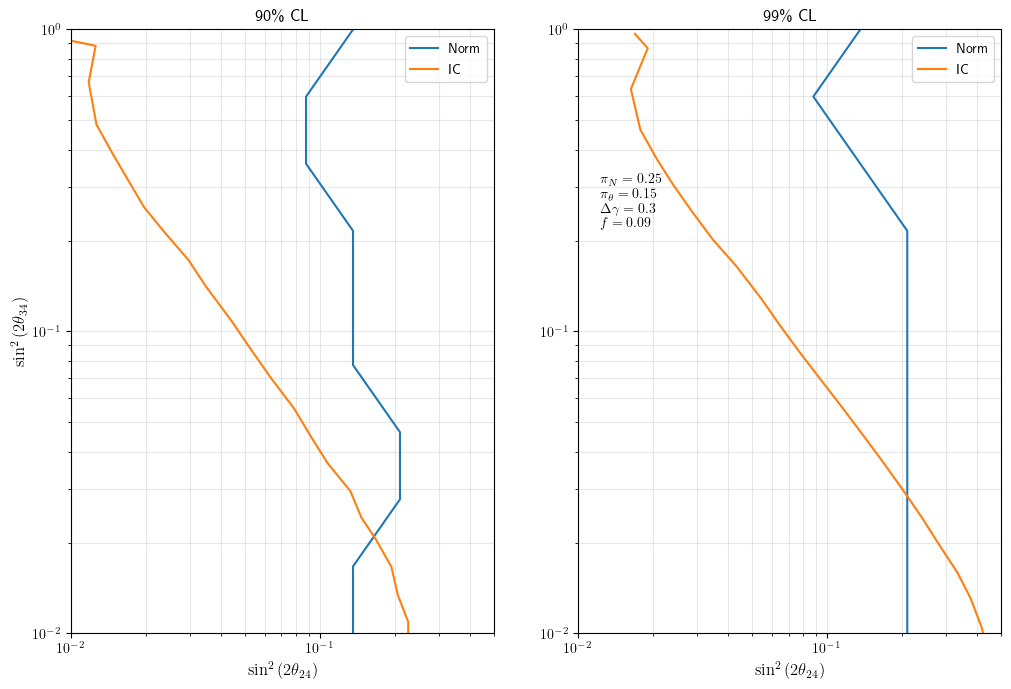

In [57]:
fig,ax = plt.subplots(1,2,figsize=(12,8))

#ax[0].plot(giunti_contour_cl90.s24, giunti_contour_cl90.dm41, label='Giunti et al. (90% CL)',c='b')
#ax[0].plot(IC_contour_cl90.s24, IC_contour_cl90.dm41, label='IceCube',c='red',ls='--')
ax[0].plot(s24_range[s24_cl90_index_list[0]], s34_range[s34_cl90_index_list[0]], label='Norm')
ax[0].plot(ic_34_cl90.s24, ic_34_cl90.s34, label='IC')
#ax[0].plot(s24_range[s24_cl90_index_list[1]], dm41_range[dm41_cl90_index_list[1]], label='Norm + zenith')
#ax[0].plot(s24_range[s24_cl90_index_list[2]], dm41_range[dm41_cl90_index_list[2]], label='Norm + zenith + tilt')

#ax[1].plot(giunti_contour_cl99.s24, giunti_contour_cl99.dm41, label='Giunti et al. (99% CL)',ls='solid',c='b')
#ax[1].plot(IC_contour_cl99.s24, IC_contour_cl99.dm41, label='IceCube',c='red',ls='--')
ax[1].plot(s24_range[s24_cl99_index_list[0]], s34_range[s34_cl99_index_list[0]], label='Norm')
ax[1].plot(ic_34_cl99.s24, ic_34_cl99.s34, label='IC')
#ax[1].plot(s24_range[s24_cl99_index_list[1]], dm41_range[dm41_cl99_index_list[1]], label='Norm + zenith')
#ax[1].plot(s24_range[s24_cl99_index_list[2]], dm41_range[dm41_cl99_index_list[2]], label='Norm + zenith + tilt')


ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[0].set_yscale('log')
ax[1].set_yscale('log')
ax[0].set_xlim((s24_range.min(), s24_range.max()))
ax[1].set_xlim((s24_range.min(), s24_range.max()))
ax[0].set_ylim((s34_range.min(), s34_range.max()))
ax[1].set_ylim((s34_range.min(), s34_range.max()))
ax[0].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[1].set_xlabel('$\sin^2{(2\\theta_{24})}$', fontsize=12)
ax[0].set_ylabel('$\sin^2{(2\\theta_{34})}$', fontsize=12)
ax[0].grid(True, which='both', alpha=0.3)
ax[1].grid(True, which='both', alpha=0.3)
ax[0].set_title('90\% CL')
ax[1].set_title('99\% CL')

ax[0].legend()
ax[1].legend()
plt.annotate(f'$\pi_N = {sigma_a}$\n$\pi_\\theta = {sigma_b}$\n$\Delta \gamma = {gamma}$\n$f = {f}$\n', 
        xy=(0.05, 0.65), xycoords='axes fraction')

#interpolare contour mesh

In [70]:
def probs(E_index, z_index, alpha, npoints, params=ic_params):
    z_buckets = np.linspace(-1,0,21)

    zr = np.linspace(z_buckets[z_index], z_buckets[z_index+1], npoints)

    Et, _, _ = get_Etrue(E_index=E_index,npoints=npoints, model=models, left_alpha=alpha, right_alpha=alpha) 
    return get_probabilities('m','m',E_index, z_index, params,False,npoints,ndim=4)


In [73]:
models= train_energy_resolution()
prob = probs(5,5,0.99,13)

In [124]:
df['ffe997099b1b68cbf466dacfaeca21e529d2f10d9f4d3042b5ba5fb33c1f092e'][f'E{En}z{zn}']

array([[0.99774881, 0.99837971, 0.99881455, 0.99911825, 0.99931717, 0.99949221, 0.99961866, 0.99970432, 0.99981958, 0.9998373 , 0.99989454, 0.99992378, 0.99993522],
       [0.99768278, 0.99835902, 0.99877199, 0.99909956, 0.99931115, 0.99945062, 0.99961438, 0.99970237, 0.99978273, 0.99986004, 0.99989374, 0.99992512, 0.99993528],
       [0.99768135, 0.9983681 , 0.99876451, 0.99908197, 0.99929978, 0.99944567, 0.99960519, 0.99969568, 0.99977407, 0.99985903, 0.99989281, 0.99991724, 0.99994118],
       [0.99768121, 0.99834136, 0.99874597, 0.9990289 , 0.99928978, 0.99944714, 0.99957797, 0.99969206, 0.99976191, 0.99985784, 0.99988998, 0.99991652, 0.9999408 ],
       [0.99760125, 0.99830583, 0.99873091, 0.99901936, 0.99922188, 0.99944098, 0.99955298, 0.99968638, 0.99975692, 0.99982571, 0.99988937, 0.99991584, 0.99994204],
       [0.99766478, 0.9981942 , 0.99869659, 0.99900949, 0.99920541, 0.9994307 , 0.99955407, 0.9996715 , 0.99975388, 0.99980408, 0.9998884 , 0.99989963, 0.9999401 ],
       [0.

In [139]:
pickle.dump(df,open(f'./pre_computed/4gen/Pmm/{npoints}/E{En}z{zn}/test','wb'))

In [140]:
hej = pickle.load(open(f'./pre_computed/4gen/Pmm/{npoints}/E{En}z{zn}/test','rb'))

In [141]:
hej

,ffe997099b1b68cbf466dacfaeca21e529d2f10d9f4d3042b5ba5fb33c1f092e,ff1ea7014045ed6f95905c0d8564edef4cd5ad6882835d0f722e7b3e5b2c06d2,fe7c3da796309666231dbcd2761b9f45890830bafeed22d9252369172755c1d4,fe3b5748a838761e0cb382bf1b8625a65b49da1cc5557b2a1aec28a3a3eb6d6c,fe19889b8eedfcbc148af06a5f467a4b428d38ffdf9331d9c35a52746d050415,fdf7d5f414ed2a8e09e69360dba0caedac0a60651452056d1755e9cfac863c6a,fdd16f5bb16c939837fe7533b769d4d3371d8a48a1237c1af97c1de1f1b11de8,fd3289d88fe6c477cb70c9105d6fd09c06c21556f017fcf11a4ffa14c7e0f67a,fd219867b4872c509750035a7dec14082acee7c293487e8cc2a2e25cc3891d5b,fd12f108d549dd055203b72c7d63dca4948ce848eecb526c4e7e56a3791be47d,...,048777009232a0fed419e151ac559d2ad849f293223f8187dd4a99e393ea5c84,0465db1c95e21d7b315d588160a428149abbf77069aa4f456e541ceaa698d2ce,04171b3de7db746446cdd345afd4304ca8f1a3340e0e545b0dba1460cfa4a8cb,02a750154a9b1d013e7ddc9053cdc0ab6051c9380b816bbe62bb934d4b6f9b9a,028cb1de8315c735defd6b96a5c38d830d8624b4479478f84cd1c3091a3fffb2,02394d8ad352a7043b411f4b028b7e5c7b5ca7ff551ffc3aee0546a40eec3b07,01d052d8e5f86c2a9c9d1a44c4c1cf6de0aac8d60b80798c89ce21ec9c60203b,0168c63b517265b2da603059f63fa483fc413247b6f7c3bac8c54823ddef2e7d,00c250f555d3b0bef44ebc438cb5d23cc3e0ea413e2280f6393347790cf763d8,00304244e2f2e047026a544cd491fe5858fa908ebfc892b96825d18c6d164603
E8z5,"[[0.9977488060710552, 0.9983797071110689, 0.99...","[[0.9839589364403017, 0.9895441042790206, 0.99...","[[0.9991633903382378, 0.9994410740150088, 0.99...","[[0.9984686004195262, 0.9975217717541764, 0.99...","[[0.9937827834778415, 0.9963924390272577, 0.99...","[[0.9974482885631378, 0.9941945231184813, 0.99...","[[0.9993979686808695, 0.9995742183668364, 0.99...","[[0.9945230121879838, 0.9967574229071035, 0.99...","[[0.9967321380851413, 0.997814152263207, 0.998...","[[0.991521089696806, 0.9950637935154537, 0.997...",...,"[[0.9979387693570569, 0.9988012042353042, 0.99...","[[0.9961397927693908, 0.9977864331849279, 0.99...","[[0.9897409837125128, 0.9929830570088823, 0.99...","[[0.999287074308815, 0.9995696577989422, 0.999...","[[0.9985587353161758, 0.998910145974735, 0.999...","[[0.7785064647718173, 0.7859645173909985, 0.83...","[[0.997671472999153, 0.9944995404216148, 0.992...","[[0.9656833470188364, 0.9790318441286794, 0.98...","[[0.9974895810239746, 0.9967960434234564, 0.99...","[[0.999618110899083, 0.9997414605849972, 0.999..."


In [142]:
hej['ffe997099b1b68cbf466dacfaeca21e529d2f10d9f4d3042b5ba5fb33c1f092e'][f'E{En}z{zn}']


array([[0.99774881, 0.99837971, 0.99881455, 0.99911825, 0.99931717, 0.99949221, 0.99961866, 0.99970432, 0.99981958, 0.9998373 , 0.99989454, 0.99992378, 0.99993522],
       [0.99768278, 0.99835902, 0.99877199, 0.99909956, 0.99931115, 0.99945062, 0.99961438, 0.99970237, 0.99978273, 0.99986004, 0.99989374, 0.99992512, 0.99993528],
       [0.99768135, 0.9983681 , 0.99876451, 0.99908197, 0.99929978, 0.99944567, 0.99960519, 0.99969568, 0.99977407, 0.99985903, 0.99989281, 0.99991724, 0.99994118],
       [0.99768121, 0.99834136, 0.99874597, 0.9990289 , 0.99928978, 0.99944714, 0.99957797, 0.99969206, 0.99976191, 0.99985784, 0.99988998, 0.99991652, 0.9999408 ],
       [0.99760125, 0.99830583, 0.99873091, 0.99901936, 0.99922188, 0.99944098, 0.99955298, 0.99968638, 0.99975692, 0.99982571, 0.99988937, 0.99991584, 0.99994204],
       [0.99766478, 0.9981942 , 0.99869659, 0.99900949, 0.99920541, 0.9994307 , 0.99955407, 0.9996715 , 0.99975388, 0.99980408, 0.9998884 , 0.99989963, 0.9999401 ],
       [0.

In [5]:
E_range = range(3,13)
z_range = range(0,20)
npoints=21
flavors = ['Pamam', 'Paeam','Pem','Pmm']
for flavor in flavors:
    for En in E_range:
        for zn in z_range:
            filenames=[]
            for file in os.listdir(f'./pre_computed/4gen/{flavor}/{npoints}/E{En}z{zn}/'):
                if file.endswith('.npy'):
                    filenames.append(file[0:-4])
            try:
                df = pickle.load(open(f'./pre_computed/4gen/{flavor}/{npoints}/E{En}z{zn}.p','rb'))
            except FileNotFoundError:
                df = pd.DataFrame(index=[f'E{En}z{zn}'], dtype='object')

            for file in filenames:
                array = np.load(f'./pre_computed/4gen/{flavor}/{npoints}/E{En}z{zn}/{file}.npy')
                df.insert(loc=0,column=file, value=[array])
            pickle.dump(df,open(f'./pre_computed/4gen/{flavor}/{npoints}/E{En}z{zn}.p','wb'))

In [28]:
for flavor in ['Pmm']:
        for En in [3]:#E_range:
            for zn in [0]:#z_range:
                filenames=[]
                try:
                    try:
                        old_df = pickle.load(open(f'./pre_computed/4gen/{flavor}/{13}/E{En}z{zn}.p','rb'))
                    except FileNotFoundError:
                        old_df = pd.DataFrame(index=[f'E{En}z{zn}'], dtype='object')

                    probs = pickle.load(open(f'./pre_computed/new/4gen/{flavor}/{13}/E{En}z{zn}.p','rb'))
                    old_df.update(probs)
                    pickle.dump(old_df,open(f'./pre_computed/4gen/{flavor}/{npoints}/E{En}z{zn}.p','wb'))
                except FileNotFoundError:
                    pass

TypeError: unhashable type: 'numpy.ndarray'

In [38]:
probs.update(old_df)

In [39]:
old_df

,ffe997099b1b68cbf466dacfaeca21e529d2f10d9f4d3042b5ba5fb33c1f092e,ff1ea7014045ed6f95905c0d8564edef4cd5ad6882835d0f722e7b3e5b2c06d2,fe7c3da796309666231dbcd2761b9f45890830bafeed22d9252369172755c1d4,fe3b5748a838761e0cb382bf1b8625a65b49da1cc5557b2a1aec28a3a3eb6d6c,fe19889b8eedfcbc148af06a5f467a4b428d38ffdf9331d9c35a52746d050415,fdf7d5f414ed2a8e09e69360dba0caedac0a60651452056d1755e9cfac863c6a,fdd16f5bb16c939837fe7533b769d4d3371d8a48a1237c1af97c1de1f1b11de8,fd3289d88fe6c477cb70c9105d6fd09c06c21556f017fcf11a4ffa14c7e0f67a,fd219867b4872c509750035a7dec14082acee7c293487e8cc2a2e25cc3891d5b,fd12f108d549dd055203b72c7d63dca4948ce848eecb526c4e7e56a3791be47d,...,048777009232a0fed419e151ac559d2ad849f293223f8187dd4a99e393ea5c84,0465db1c95e21d7b315d588160a428149abbf77069aa4f456e541ceaa698d2ce,04171b3de7db746446cdd345afd4304ca8f1a3340e0e545b0dba1460cfa4a8cb,02a750154a9b1d013e7ddc9053cdc0ab6051c9380b816bbe62bb934d4b6f9b9a,028cb1de8315c735defd6b96a5c38d830d8624b4479478f84cd1c3091a3fffb2,02394d8ad352a7043b411f4b028b7e5c7b5ca7ff551ffc3aee0546a40eec3b07,01d052d8e5f86c2a9c9d1a44c4c1cf6de0aac8d60b80798c89ce21ec9c60203b,0168c63b517265b2da603059f63fa483fc413247b6f7c3bac8c54823ddef2e7d,00c250f555d3b0bef44ebc438cb5d23cc3e0ea413e2280f6393347790cf763d8,00304244e2f2e047026a544cd491fe5858fa908ebfc892b96825d18c6d164603
E3z0,1,"[[0.9680235337303964, 0.9853988985363079, 0.97...","[[0.9876050163679787, 0.9836180918195547, 0.97...","[[0.9907181861776847, 0.9899142827631761, 0.98...","[[0.9682492687941872, 0.9873449848938949, 0.97...","[[0.9893345528054244, 0.9919998296247481, 0.99...","[[0.9844857180902008, 0.9807734011926281, 0.98...","[[0.9539315464527394, 0.9409689576714028, 0.97...","[[0.9608754892857347, 0.9647308939832191, 0.94...","[[0.9583981143309682, 0.9827328215151744, 0.95...",...,"[[0.9865311957034121, 0.9939787097559776, 0.98...","[[0.9858719175536407, 0.975410176852884, 0.974...","[[0.9782190264128258, 0.989685473369869, 0.980...","[[0.9854782677747177, 0.991027188775994, 0.995...","[[0.9445703926352166, 0.9442715895987209, 0.95...","[[0.909906914189072, 0.6899339979301403, 0.893...","[[0.9899077193109408, 0.9924966525445366, 0.99...","[[0.8234627376709595, 0.874925047598834, 0.793...","[[0.9877023325828787, 0.9848942105524816, 0.98...","[[0.9923190901438358, 0.9915487096267028, 0.99..."


In [37]:
old_df.iloc[0][0] = 1
old_df

,ffe997099b1b68cbf466dacfaeca21e529d2f10d9f4d3042b5ba5fb33c1f092e,ff1ea7014045ed6f95905c0d8564edef4cd5ad6882835d0f722e7b3e5b2c06d2,fe7c3da796309666231dbcd2761b9f45890830bafeed22d9252369172755c1d4,fe3b5748a838761e0cb382bf1b8625a65b49da1cc5557b2a1aec28a3a3eb6d6c,fe19889b8eedfcbc148af06a5f467a4b428d38ffdf9331d9c35a52746d050415,fdf7d5f414ed2a8e09e69360dba0caedac0a60651452056d1755e9cfac863c6a,fdd16f5bb16c939837fe7533b769d4d3371d8a48a1237c1af97c1de1f1b11de8,fd3289d88fe6c477cb70c9105d6fd09c06c21556f017fcf11a4ffa14c7e0f67a,fd219867b4872c509750035a7dec14082acee7c293487e8cc2a2e25cc3891d5b,fd12f108d549dd055203b72c7d63dca4948ce848eecb526c4e7e56a3791be47d,...,048777009232a0fed419e151ac559d2ad849f293223f8187dd4a99e393ea5c84,0465db1c95e21d7b315d588160a428149abbf77069aa4f456e541ceaa698d2ce,04171b3de7db746446cdd345afd4304ca8f1a3340e0e545b0dba1460cfa4a8cb,02a750154a9b1d013e7ddc9053cdc0ab6051c9380b816bbe62bb934d4b6f9b9a,028cb1de8315c735defd6b96a5c38d830d8624b4479478f84cd1c3091a3fffb2,02394d8ad352a7043b411f4b028b7e5c7b5ca7ff551ffc3aee0546a40eec3b07,01d052d8e5f86c2a9c9d1a44c4c1cf6de0aac8d60b80798c89ce21ec9c60203b,0168c63b517265b2da603059f63fa483fc413247b6f7c3bac8c54823ddef2e7d,00c250f555d3b0bef44ebc438cb5d23cc3e0ea413e2280f6393347790cf763d8,00304244e2f2e047026a544cd491fe5858fa908ebfc892b96825d18c6d164603
E3z0,1,"[[0.9680235337303964, 0.9853988985363079, 0.97...","[[0.9876050163679787, 0.9836180918195547, 0.97...","[[0.9907181861776847, 0.9899142827631761, 0.98...","[[0.9682492687941872, 0.9873449848938949, 0.97...","[[0.9893345528054244, 0.9919998296247481, 0.99...","[[0.9844857180902008, 0.9807734011926281, 0.98...","[[0.9539315464527394, 0.9409689576714028, 0.97...","[[0.9608754892857347, 0.9647308939832191, 0.94...","[[0.9583981143309682, 0.9827328215151744, 0.95...",...,"[[0.9865311957034121, 0.9939787097559776, 0.98...","[[0.9858719175536407, 0.975410176852884, 0.974...","[[0.9782190264128258, 0.989685473369869, 0.980...","[[0.9854782677747177, 0.991027188775994, 0.995...","[[0.9445703926352166, 0.9442715895987209, 0.95...","[[0.909906914189072, 0.6899339979301403, 0.893...","[[0.9899077193109408, 0.9924966525445366, 0.99...","[[0.8234627376709595, 0.874925047598834, 0.793...","[[0.9877023325828787, 0.9848942105524816, 0.98...","[[0.9923190901438358, 0.9915487096267028, 0.99..."


In [30]:
probs

,ffe997099b1b68cbf466dacfaeca21e529d2f10d9f4d3042b5ba5fb33c1f092e,ff1ea7014045ed6f95905c0d8564edef4cd5ad6882835d0f722e7b3e5b2c06d2,fe7c3da796309666231dbcd2761b9f45890830bafeed22d9252369172755c1d4,fe3b5748a838761e0cb382bf1b8625a65b49da1cc5557b2a1aec28a3a3eb6d6c,fe19889b8eedfcbc148af06a5f467a4b428d38ffdf9331d9c35a52746d050415,fdf7d5f414ed2a8e09e69360dba0caedac0a60651452056d1755e9cfac863c6a,fdd16f5bb16c939837fe7533b769d4d3371d8a48a1237c1af97c1de1f1b11de8,fd3289d88fe6c477cb70c9105d6fd09c06c21556f017fcf11a4ffa14c7e0f67a,fd219867b4872c509750035a7dec14082acee7c293487e8cc2a2e25cc3891d5b,fd12f108d549dd055203b72c7d63dca4948ce848eecb526c4e7e56a3791be47d,...,048777009232a0fed419e151ac559d2ad849f293223f8187dd4a99e393ea5c84,0465db1c95e21d7b315d588160a428149abbf77069aa4f456e541ceaa698d2ce,04171b3de7db746446cdd345afd4304ca8f1a3340e0e545b0dba1460cfa4a8cb,02a750154a9b1d013e7ddc9053cdc0ab6051c9380b816bbe62bb934d4b6f9b9a,028cb1de8315c735defd6b96a5c38d830d8624b4479478f84cd1c3091a3fffb2,02394d8ad352a7043b411f4b028b7e5c7b5ca7ff551ffc3aee0546a40eec3b07,01d052d8e5f86c2a9c9d1a44c4c1cf6de0aac8d60b80798c89ce21ec9c60203b,0168c63b517265b2da603059f63fa483fc413247b6f7c3bac8c54823ddef2e7d,00c250f555d3b0bef44ebc438cb5d23cc3e0ea413e2280f6393347790cf763d8,00304244e2f2e047026a544cd491fe5858fa908ebfc892b96825d18c6d164603
E3z0,"[[0.9427267214150279, 0.9286070511152447, 0.93...","[[0.9680235337303964, 0.9853988985363079, 0.97...","[[0.9876050163679787, 0.9836180918195547, 0.97...","[[0.9907181861776847, 0.9899142827631761, 0.98...","[[0.9682492687941872, 0.9873449848938949, 0.97...","[[0.9893345528054244, 0.9919998296247481, 0.99...","[[0.9844857180902008, 0.9807734011926281, 0.98...","[[0.9539315464527394, 0.9409689576714028, 0.97...","[[0.9608754892857347, 0.9647308939832191, 0.94...","[[0.9583981143309682, 0.9827328215151744, 0.95...",...,"[[0.9865311957034121, 0.9939787097559776, 0.98...","[[0.9858719175536407, 0.975410176852884, 0.974...","[[0.9782190264128258, 0.989685473369869, 0.980...","[[0.9854782677747177, 0.991027188775994, 0.995...","[[0.9445703926352166, 0.9442715895987209, 0.95...","[[0.909906914189072, 0.6899339979301403, 0.893...","[[0.9899077193109408, 0.9924966525445366, 0.99...","[[0.8234627376709595, 0.874925047598834, 0.793...","[[0.9877023325828787, 0.9848942105524816, 0.98...","[[0.9923190901438358, 0.9915487096267028, 0.99..."
